In [ ]:
!wget https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/fake_news_2_classification.csv
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import sys  
!{sys.executable} -m pip install contractions

!pip install spacy
!python -m spacy download es_core_news_sm



--2021-06-04 18:37:36--  https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/fake_news_2_classification.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/fake_news_2_classification.csv [following]
--2021-06-04 18:37:37--  https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/fake_news_2_classification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3867470 (3.7M) [text/plain]
Saving to: ‘fake_news_2_classification.csv’

fake_news_2_classif 100%[===================>]   3.69M  --.-KB/s    in 0.1s    

2021-06-04 18:

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import string 
import re 
import contractions 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Cargar y preparar los datos


En primer lugar, cargaremos la base de datos descarga anteriormente con titulares de noticias falsas y noticias verdaderas

In [ ]:
# Leer el dataset con pandas read_csv (separador \t)
dataset = ______________________

In [ ]:
dataset

Vamos a comprobar el tamaño del dataset:

In [ ]:
print("Tenemos un conjunto de {} documentos".format(________________))


Tenemos un conjunto de 59601 documentos


In [ ]:
print("El dataframe tiene {} columnas".format(______________________________)) # Ayuda: con dataset.shape

El dataframe tiene 2 columnas


Despues, quitaremos las filsa con algún valor vacío (NA) y quitaremos los duplicados.

In [ ]:
print("Existen {} noticias duplicadas".format(np.sum(__________________________))))

Existen 30 noticias duplicadas


In [ ]:
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} noticias".format(_____________________))

Despues de quitar duplicados tenemos un conjunto de 59571 noticias


Despues de esto, comprobaramos que no hayan quedado Nulls en ningunas de las dos columnas del dataset

In [ ]:
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


# Análisis preliminar

## Etiquetas

Vamos a comprobar el número de etiquetas de cada clase en la columna "fake", la columna correpondiente a lasetiquetas.

In [ ]:
dataset["fake"].____________________________

0    30000
1    29571
Name: fake, dtype: int64

¡¡Tenemos un dataset balanceado!! Esto nos evitará problemas en el entrenamiento de los modelos😀. 

Disponemos 30000 noticias verdaderas (valor 0) y 29571 noticias falsas (valor 1).

Vamos a dibujar un histograma con las clases así practicamos:

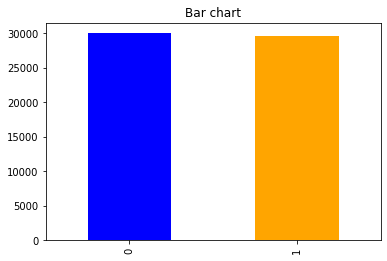

In [ ]:
ax, fig = plt.subplots()
etiquetas = dataset.fake.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

## Distribución longitudes

Para seguir con el análisis exploratorio, vamos a hacer un cálculo típico: la longitud de cada uno de los textos de los documentos para despues dibujar su histograma. 

También se podría tokenizar y después extraer esta distribución, pero por seguir los pasos lógicos marcados durante la clase, lo haremos ahora.

In [ ]:
# Utilizar apply y lambda x
dataset["char_len"] = dataset["title"].apply(_____________________________________)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
fig = plt.figure(figsize=(10,6))
plt1 = sns.distplot(________________________, hist=True, label="real") # Filtar elementos "fake"=0 y coger alor de char_len
plt2 = sns.distplot(________________________, hist=True, label="fake") # Filtar elementos "fake"=1 y coger alor de char_len
fig.legend(labels=['real','fake'])
plt.show()

Una noticia interesante! Vemos que las distribuciones de longitud de los titulares cambian en función de la veracidad de la noticia. La longitud de las noticias falsas suelen tener una logitud mayor. 
Esto es un dato muy interesante, viendo la separación de estas variables podríamos entrenar un "clasificador" que funcionara bastante bien con la regla `if len(noticia)>50 "fake" else "verdad"`


# Transformación
Como hemos visto, está dividido en dos pasos Normalización o Preprocesado y Transformación

## Normalización
Vamos a proceder a normalizar los datos. Para ello vamos a generar pequeñas funciones que nos permitan:
- Eliminar espacios extra.
- Transformar a minúsculas.
- Tokenizar.
- Reemplazar contractions.
- Lematizar tokens.
- Eliminar stopwords.
- Eliminar sígnos de puntuación.

In [ ]:
# Eliminar espacios
def eliminar_espacios(text): 
    return  " ".join(text.split()) 

# To lower
def texto_to_lower(text):
  return text.lower()

# Tokenizador utilizando nltk 
def tokenization(text):
  tokens = _______________________
  return tokens

# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    for t in text.split():
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words


# Lemmatization
import es_core_news_sm
nlp = es_core_news_sm.load(disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)


import string
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem(tokens):
    tokens = [ ____________________ for token in tokens]
    return tokens


Podríamos generar una función de transformación que aglutinara todas las anteriores y pasársela al siguiente paso (TfidfVectorizer) en el campo analyzer. Para ver el proceso de cada uno de los pasos lo haremos paso a paso:



In [ ]:
# Quitar Espacios
dataset["normaliza"] = dataset["title"].progress_apply(lambda x: _______________(x))
# To Lower
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: ________________(x))
# Contraciones
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: _____________(x))
# Tokenizar
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: ______________(x))
# Quitar Stopwords
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: ______________(x))
# Quitar puntuación
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: _______________________(x))
# Stemming
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: _______________(x))
# Mirar todo lo que tarda con lematización (mediante spacy)
#dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: lematizar(x))

dataset["normaliza"]



Posteriormente podríamos crear una función que preprocesara los textos según nuestras necesidades:


In [ ]:
# Hacer como ejercicio de clase
def preprocesado_fakenews(sentence, remove_spaces =True)
  if (remove_spaces):
    sentence = eliminar_espacios(x)
  sentence = texto_to_lower(sentence)
 ......

Como explicamos ayer, se ha hecho el preprocesado, y antes de introducirlo a TFIDF vamos a generar una frase de gada una de las listas de tokens, para utilizar el propio tokenizador de TFIDF.

In [ ]:
dataset["clean_text"] = dataset["normaliza"].progress_apply(lambda x: " ".join(x))

Podríamos visualizar la longitud de en tokens de los textos una vez hecha la limpieza anterior:

In [ ]:
dataset["token_len"] = ______________________________________


fig = plt.figure(figsize=(10,6))
plt1 = sns.distplot(______________________, hist=True, label="real")
plt2 = sns.distplot(______________________, hist=True, label="fake")
fig.legend(labels=['real','fake'])
plt.show()

## Vectorizacion

Con todo  generado, vamos a extraer las características utilizando TFIDVectorizer:
- Queremos utilizar como máximo 300 features
- unigramas, bigramas y trigramas
- Que el sistema no considere los elementos que salgan en menos del 5% de los documentos.

In [ ]:
vectorizador = TfidfVectorizer(_____________________________________)

# Transformamos el dataset limpiado anteriormente
vector_data = vectorizador.fit_transform(______________________)

# Entrenar/validar el clasificador:

En primer lugar, dividamos el dataset en Train/Test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vector_data, dataset.fake, random_state=0)
print(X_train.shape)
print(X_test.shape)

Vamos a entrenar el modelo. 
Dado que es un problema binario, vamos a utilizar un regresorLogístico para realizar la clasificación. Los parámetros del regresor son "solvers","penalty" y "c_values" (el más importante). 
Vamos a hacer una grid_search para ver cuales son los mejores valores.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]


Vamos a generar un diccionario para la búsqueda Grid y también generaremos el objeto GridSearchCV. Vamos a utilizar una métrica de búsqueda basada en accuracy (por probar)

In [ ]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Entrenamos el modelo y hacemos un "print" del mejor resultado:

In [ ]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))


Podría interesarnos más otro de los resultados, así que vamos a mostrar todos. 
Primero asignamos la accuracy media de cada modelo a una variable (means), la std y los parametros y hacemos un bucle for.

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) con parámetros: %r" % (mean, stdev, param))

Tenemos modelo! Los resultados mejores deben ser introducidos a un modelo específico para ser entrenado:

In [ ]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(____________________________________)
model.fit(X_train,y_train)


Predecimos con el set de test, y creamos una matriz de confusión y un "classification report".

In [ ]:
# Predecimos con el clasificador "model" la clase de los datos de X_test
y_pred = ________________________________

Vamos a calcular la matriz de confusión con el test set y el classification report (utilizando y_test, y_pred)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(_______,________))
print(classification_report(_______,_______))

Además podemos pintar esa matriz de confusión para tener los resultados más "bonitos".

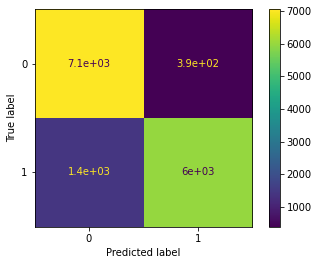

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, normalize = None)

Si quisieramos aplicar el modelo a nuevos datos, tendríamos que preprocesarlo del mismo modo que a los datos de entrenamiento y deberíamos transformarlo con el TFIDFVectorizar anteriormente entrenado. Despues de eso ya se podría incorporar sin problemas al `model.predict(Xnew)`